## Вступ

Цільовим завданням цього проекту було прогнозування цін на акції компаній Tesla і Amazon на основі історичних даних цін. Для досягнення цієї мети були використані два основні підходи: лінійна регресія та рекурентна LSTM нейромережа. Даний звіт описує процес обробки та аналізу даних, побудови моделей і оцінки їх ефективності.

## 1. Збір та обробка даних

Для цього проекту я використовував історичні дані цін на акції компаній Tesla і Amazon. Дані були завантажені з фінансових джерел і збережені у форматі CSV. Для обох компаній були використані дані про ціну закриття акцій.

Дані були оброблені наступним чином:

Для лінійної регресії: \
Сортування даних по даті. \
Перетворення дати в індекс. \
Перетворення даних у масив numpy. \
Розділення даних на навчальну та тестову вибірки.

Для нейромережі: \
Використання лише колонки про ціну закриття \
Перетворення даних у масив numpy \
Нормалізація даних \
Х - створено на основі даних про ціну закриття останіх 60 днів \
у - ціна закриття, яку ми передбачаємо

## 2. Модель лінійної регресії

Першою моделлю, якою було зайнятося, була лінійна регресія. Я використовував бібліотеку Scikit-Learn для побудови моделі. Основними ознаками для прогнозування були лише дані за останій день, такі як: open, high, low, volume

Результати лінійної регресії були наступними:

Tesla: MSE прогнозування складала приблизно 98 \
Amazon: MSE прогнозування складала приблизно 278
## 3. Модель рекурентної LSTM нейромережі

Другою моделлю, якою я займався, була рекурентна LSTM нейромережа. Я використовував бібліотеку keras для побудови моделі. Вхідними даними для моделі були послідовності цін на акції на попередні 60 днів.

Результати рекурентної LSTM нейромережі були наступними:

Tesla: MSE прогнозування складала приблизно 0.044 \
Amazon: MSE прогнозування складала приблизно 4

## Висновки

У результаті цього проекту я успішно спргнозував ціни на акції компаній Tesla і Amazon за допомогою двох моделей: лінійної регресії та рекурентної LSTM нейромережі. Рекурентна нейромережа показала кращі результати у порівнянні з лінійною регресією. Цей проект підкреслив важливість використання глибокого навчання для аналізу фінансових даних та прогнозування ринкових показників.

In [294]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [295]:
from datetime import datetime
from sklearn.model_selection import cross_val_score

In [296]:
from sklearn.model_selection import train_test_split

In [297]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [298]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [299]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [300]:
key = 'MVDT7Q436AV8LIM4'

In [301]:
url_amazon = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AMZN&outputsize=full&apikey={key}&datatype=csv'

In [302]:
url_tesla = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=TSLA&outputsize=full&apikey={key}&datatype=csv'

In [303]:
data_amazon = pd.read_csv(url_amazon)
data_tesla = pd.read_csv(url_tesla)

In [304]:
df_amazon = pd.DataFrame(data_amazon, columns=['timestamp', 'open', 'high', 'low', 'volume', 'close'])
df_tesla = pd.DataFrame(data_tesla, columns=['timestamp', 'open', 'high', 'low', 'volume', 'close'])

In [305]:
df_amazon.head()

,timestamp,open,high,low,volume,close
0,2023-10-19,130.565,132.2400,127.470,60961355,128.40
1,2023-10-18,129.900,130.6699,127.510,42699479,128.13
2,2023-10-17,130.390,132.5800,128.710,49344550,131.47
3,2023-10-16,130.690,133.0700,130.425,42832918,132.55
4,2023-10-13,132.980,133.3145,128.950,45824685,129.79


In [306]:
df_tesla.head()

,timestamp,open,high,low,volume,close
0,2023-10-19,225.95,230.6100,216.78,170772713,220.11
1,2023-10-18,252.70,254.6300,242.08,125147846,242.68
2,2023-10-17,250.10,257.1830,247.08,93562909,254.85
3,2023-10-16,250.05,255.3999,248.48,88917176,253.92
4,2023-10-13,258.90,259.6000,250.22,102296786,251.12


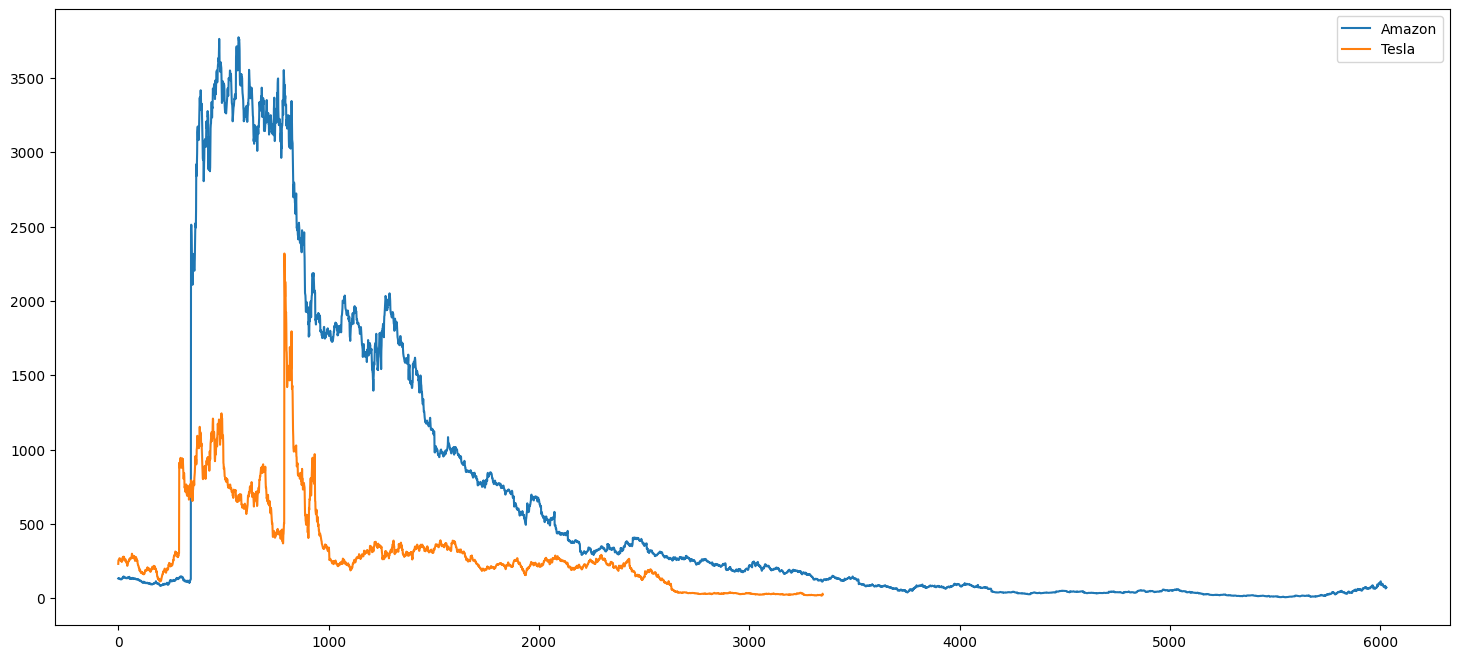

In [307]:
plt.figure(figsize=(18, 8))
df_amazon.high.plot()
df_tesla.high.plot()
plt.legend(['Amazon', 'Tesla'])
plt.show()

In [308]:
# функція для перевірки та візуалізації даних
def data_validation(data):
    print(data.info(), sep='\n')

    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data = data.set_index('timestamp')
    data = data.sort_index()

    plt.figure(figsize=(12, 6))
    plt.plot(data['close'], marker='o', linestyle='-')
    plt.title('Зміна цін на акції з часом')
    plt.xlabel('Час')
    plt.ylabel('Ціна акцій')
    plt.grid(True)
    plt.show()
    
    #дивимось як змінюється ціна з часом
    plt.figure(figsize=(12, 6))
    plt.plot(data['close'])
    plt.plot(data['high'])
    plt.plot(data['low'])
    
    plt.title('Зміна цін на акції з часом')
    plt.xlabel('Час')
    plt.ylabel('Ціна акцій')
    plt.grid(True)
    plt.legend(['close', 'high', 'low'])
    plt.show()

    plt.figure(figsize=(12, 6))  

    # Побудова графіка обсягу торгів
    plt.plot(data['volume'], label='Обсяг торгів', color='blue')
    
    plt.xlabel('Дата')
    plt.ylabel('Обсяг торгів')
    plt.title('Графік обсягу торгів')
    
    plt.legend()
    plt.show()
    
    #дивимось як дані корелюють між собою
    cor = data.corr()

    sns.heatmap(cor, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Кореляційна матриця')
    plt.show()

    selected_columns = data[['open', 'close', 'high', 'low']]
    plt.boxplot(selected_columns.values, sym='b+', patch_artist=True, labels=selected_columns.columns)
    plt.xticks(range(1, len(['open', 'close', 'high', 'low']) + 1), ['open', 'close', 'high', 'low'])
    plt.title('Boxplot для різних стовпців')
    plt.xlabel('Стовпці')
    plt.ylabel('Значення')
    plt.grid(True)  
    plt.figure(figsize=(10, 6))  

    plt.show()
    
    return data

# Проводимо аналіз даних Amazon

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6031 entries, 0 to 6030
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  6031 non-null   object 
 1   open       6031 non-null   float64
 2   high       6031 non-null   float64
 3   low        6031 non-null   float64
 4   volume     6031 non-null   int64  
 5   close      6031 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 282.8+ KB
None


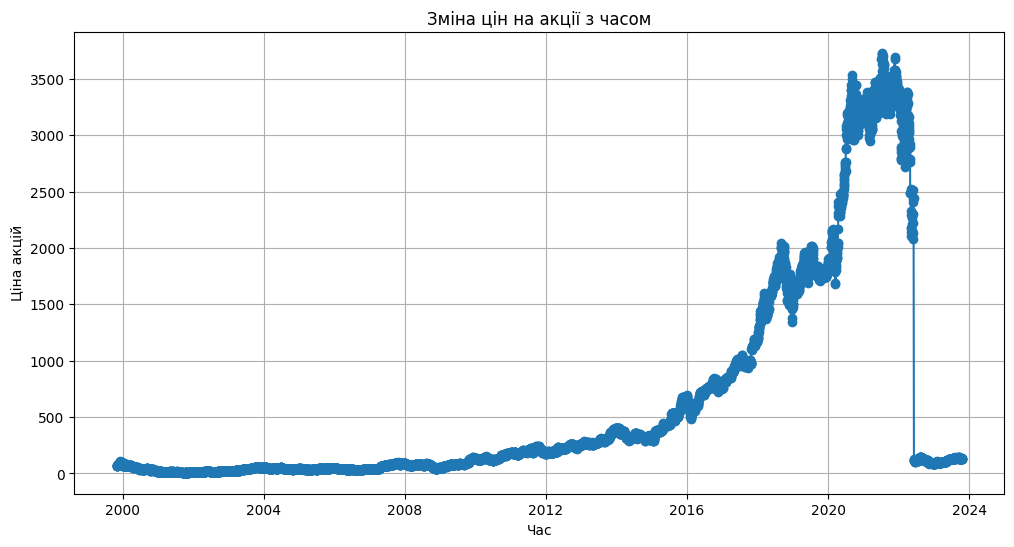

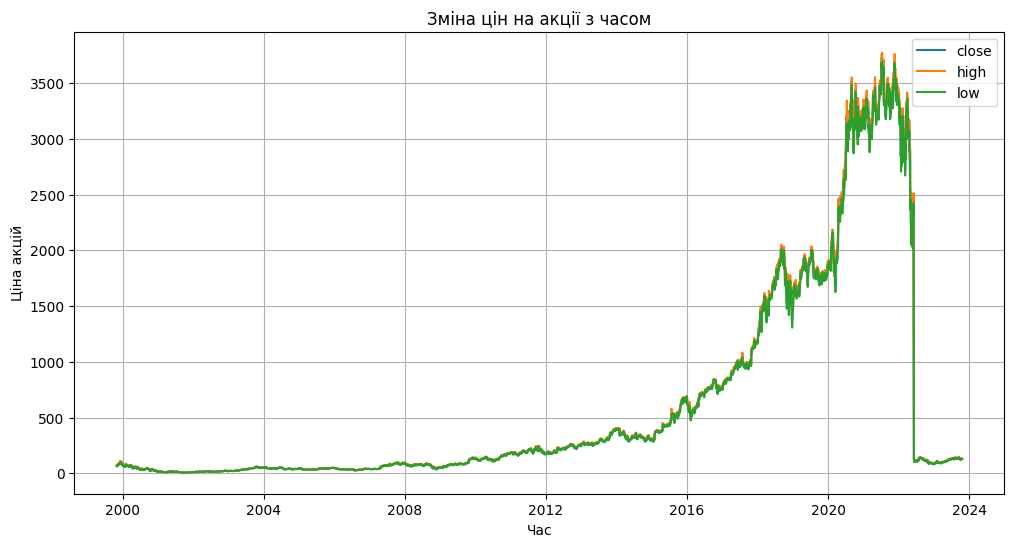

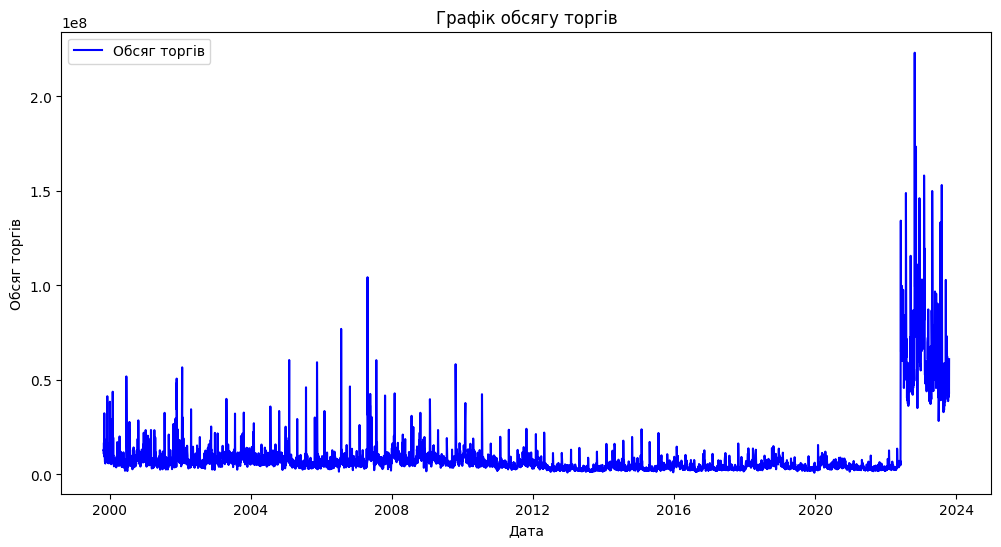

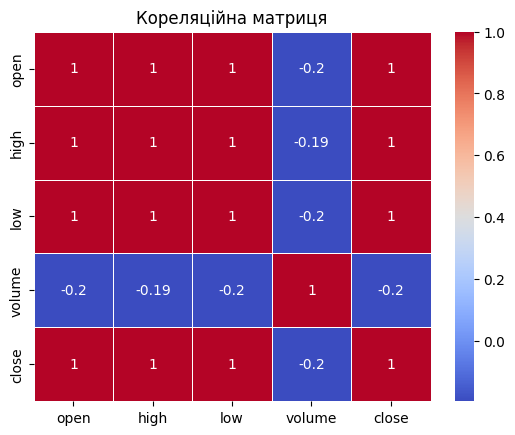

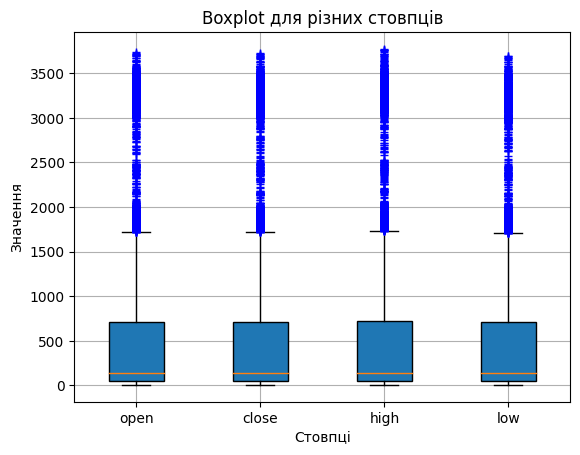

<Figure size 1000x600 with 0 Axes>

In [309]:
df_amazon = data_validation(df_amazon)

In [310]:
df_amazon[df_amazon.index>'2022-04-25'].head()

,open,high,low,volume,close
timestamp,,,,,
2022-04-26,2896.00,2897.115,2778.59,3781514,2787.82
2022-04-27,2803.83,2838.970,2715.67,3566815,2763.34
2022-04-28,2843.56,2918.750,2806.00,5865847,2891.93
2022-04-29,2596.98,2615.220,2432.50,13633086,2485.63
2022-05-02,2448.02,2493.365,2367.50,7439449,2490.00


In [311]:
# спостерігаємо різке змінення ціни
df_amazon[df_amazon.index>'2022-06-01'].head()

,open,high,low,volume,close
timestamp,,,,,
2022-06-02,2433.680,2512.20,2400.900,5028034,2510.22
2022-06-03,2484.000,2488.00,2420.929,4880166,2447.00
2022-06-06,125.245,128.99,123.810,134271125,124.79
2022-06-07,122.005,124.10,120.630,85156712,123.00
2022-06-08,122.610,123.75,120.750,64926594,121.18


# Проводимо аналіз даних Tesla

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3351 entries, 0 to 3350
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  3351 non-null   object 
 1   open       3351 non-null   float64
 2   high       3351 non-null   float64
 3   low        3351 non-null   float64
 4   volume     3351 non-null   int64  
 5   close      3351 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 157.2+ KB
None


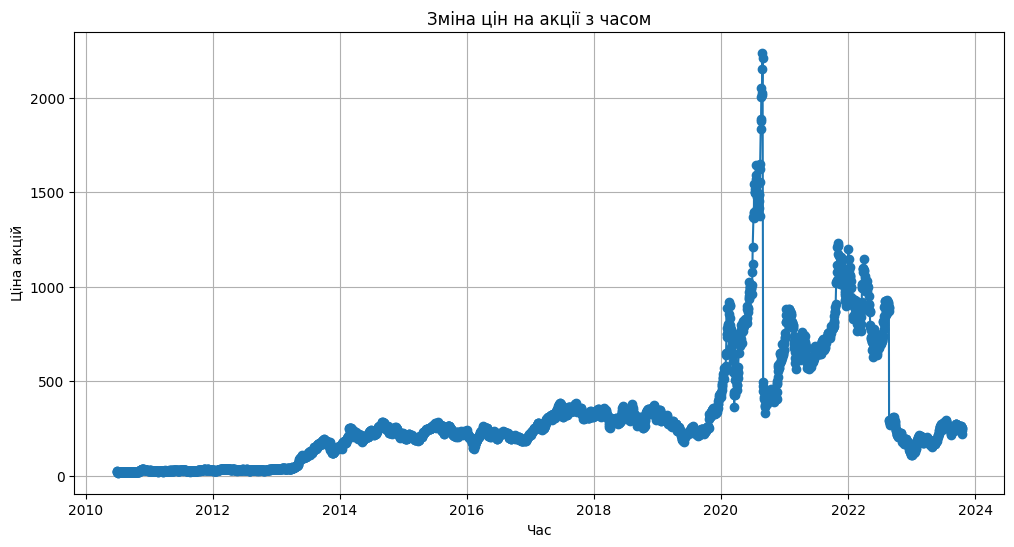

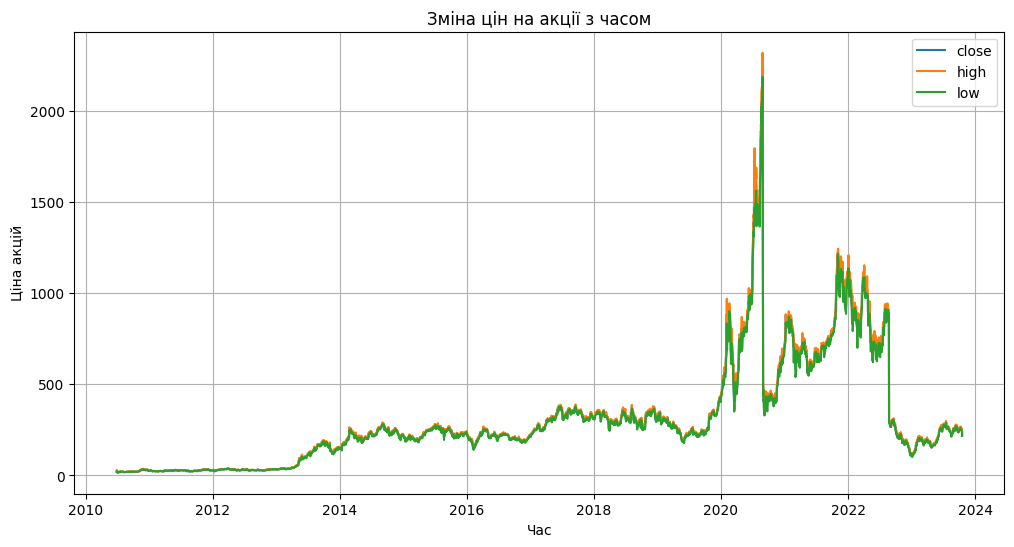

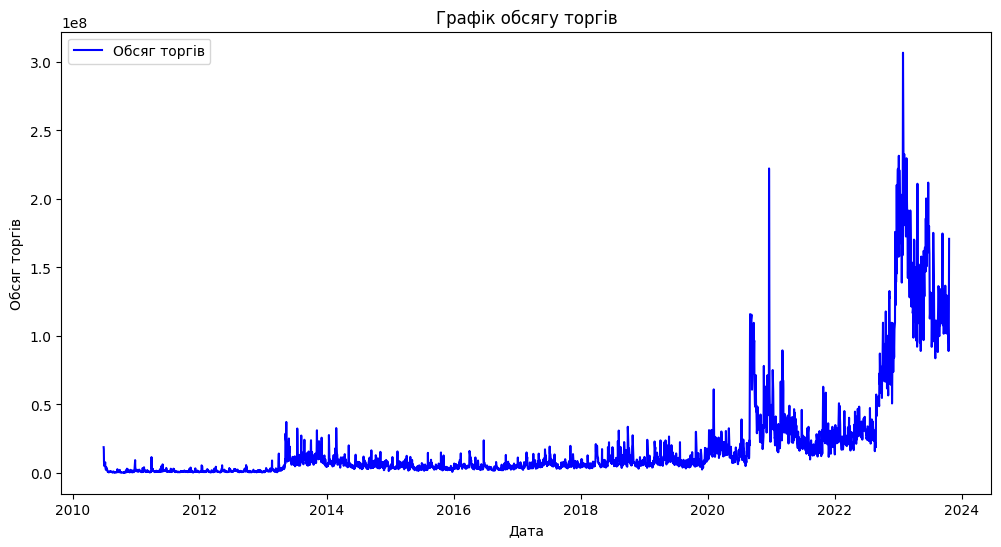

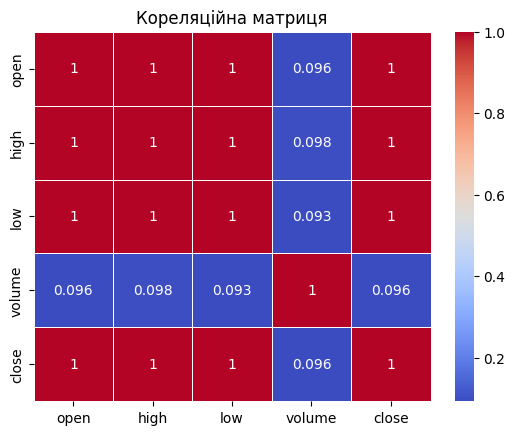

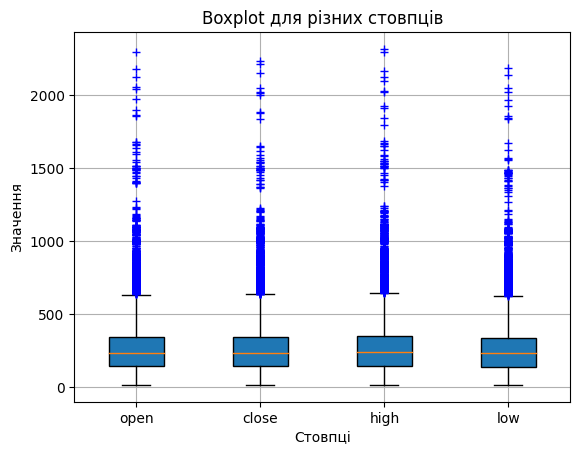

<Figure size 1000x600 with 0 Axes>

In [312]:
df_tesla = data_validation(df_tesla)

In [313]:
df_tesla[df_tesla['close'] > 1050].head(10)

,open,high,low,volume,close
timestamp,,,,,
2020-06-30,1006.50,1087.69,1003.73,16918501,1079.81
2020-07-01,1083.00,1135.33,1080.50,13326897,1119.63
2020-07-02,1221.48,1228.00,1185.60,17250127,1208.66
2020-07-06,1276.69,1377.79,1266.04,20570284,1371.58
2020-07-07,1405.01,1429.50,1336.71,21493301,1389.86
2020-07-08,1405.00,1417.26,1311.34,16330188,1365.88
2020-07-09,1396.99,1408.56,1351.28,11718292,1394.28
2020-07-10,1396.00,1548.92,1376.01,23346353,1544.65
2020-07-13,1659.00,1794.99,1471.11,39003179,1497.06


In [314]:
df_tesla[df_tesla.index>'2020-08-25'].head()

,open,high,low,volume,close
timestamp,,,,,
2020-08-26,2060.00,2166.00,2053.6291,14239382,2153.17
2020-08-27,2180.46,2295.60,2142.5000,23693043,2238.75
2020-08-28,2295.12,2318.49,2186.5200,20081176,2213.40
2020-08-31,444.61,500.14,440.1100,115847020,498.32
2020-09-01,502.14,502.49,470.5100,90119419,475.05


In [315]:
df_tesla[df_tesla['close'] > 1208.66].count()

open      43
high      43
low       43
volume    43
close     43
dtype: int64

In [316]:
# різька зміна ціни
df_tesla[df_tesla.index>'2020-08-25'].head() 

,open,high,low,volume,close
timestamp,,,,,
2020-08-26,2060.00,2166.00,2053.6291,14239382,2153.17
2020-08-27,2180.46,2295.60,2142.5000,23693043,2238.75
2020-08-28,2295.12,2318.49,2186.5200,20081176,2213.40
2020-08-31,444.61,500.14,440.1100,115847020,498.32
2020-09-01,502.14,502.49,470.5100,90119419,475.05


# Створення лінійної регресії

In [317]:
def linear_regression(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Зробимо прогнози на тестових даних
    predictions = model.predict(X_test)

    # # Обчислимо середню абсолютну похибку (Mean Absolute Error)
    mean_mse = mean_squared_error(y_test, predictions)

    return model, predictions, mean_mse

In [318]:
def predictions_plot(predictions, y_test):
    df_pred = pd.DataFrame({'close': y_test, 'predictions': predictions})

    plt.figure(figsize=(16, 8))
    plt.title('Модель')
    plt.xlabel('Дата', fontsize=18)
    plt.ylabel('Ціна закриття', fontsize=18)
    plt.plot(df_pred['close'])
    plt.plot(df_pred['predictions'])
    plt.legend(['Real data', 'Predictions'], loc='lower right')
    plt.show()

## Навчання та прогноз на даних Amazon

In [319]:
# розбиваємо на X та у та переводимо дані до numpy array
X_az = df_amazon.drop(['close'], axis=1).values
y_az = df_amazon['close'].values

# розбиваємо дані на тренувальні та тестові і навчаємо модель
X_train_az, X_test_az, y_train_az, y_test_az = train_test_split(X_az, y_az, test_size=0.2, shuffle=False)
model_az, predictions_az, mean_mse_az = linear_regression(X_train_az, X_test_az, y_train_az, y_test_az)

In [320]:
mean_mse_az

278.75852040441714

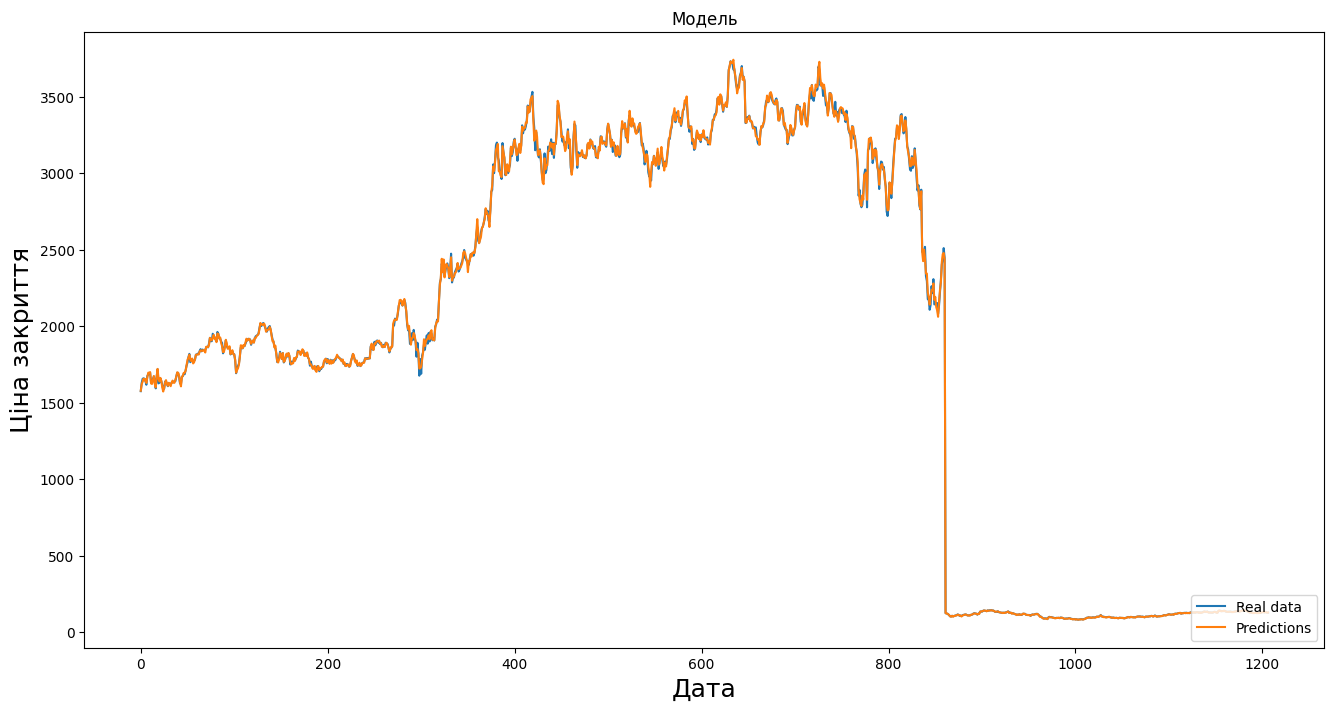

In [321]:
predictions_plot(predictions_az, y_test_az)

## Передбачаємо сьогоднішню ціну на акції Amazon

In [322]:
new_data_az = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AMZN&outputsize=full&apikey={key}&datatype=csv')

In [323]:
today_data_az = new_data_az[new_data_az['timestamp'] == '2023-10-18']

In [324]:
X_today_data_az = today_data_az.filter(['open', 'high', 'low', 'volume']).values
y_today_data_az = today_data_az.filter(['close']).values

In [325]:
pred_today_az = model_az.predict(X_today_data_az)

In [326]:
print(new_data_az['timestamp'].iloc[0])
print("Передбачувана ціна:", *pred_today_az)
print("Реальна:", *y_today_data_az[0])

2023-10-19
Передбачувана ціна: 128.25766439320884
Реальна: 128.13


## Навчання та прогноз на даних Tesla

In [327]:
# розбиваємо на X та у та переводимо дані до numpy array
X_tl = df_tesla.drop(['close'], axis=1)
y_tl = df_tesla['close']

# розбиваємо дані на тренувальні та тестові і навчаємо модель
X_train_tl, X_test_tl, y_train_tl, y_test_tl = train_test_split(X_tl, y_tl, test_size=0.2, shuffle=False)
model_tl, predictions_tl, mean_mae_tl = linear_regression(X_train_tl, X_test_tl, y_train_tl, y_test_tl)

In [328]:
mean_mae_tl

98.61259342580145

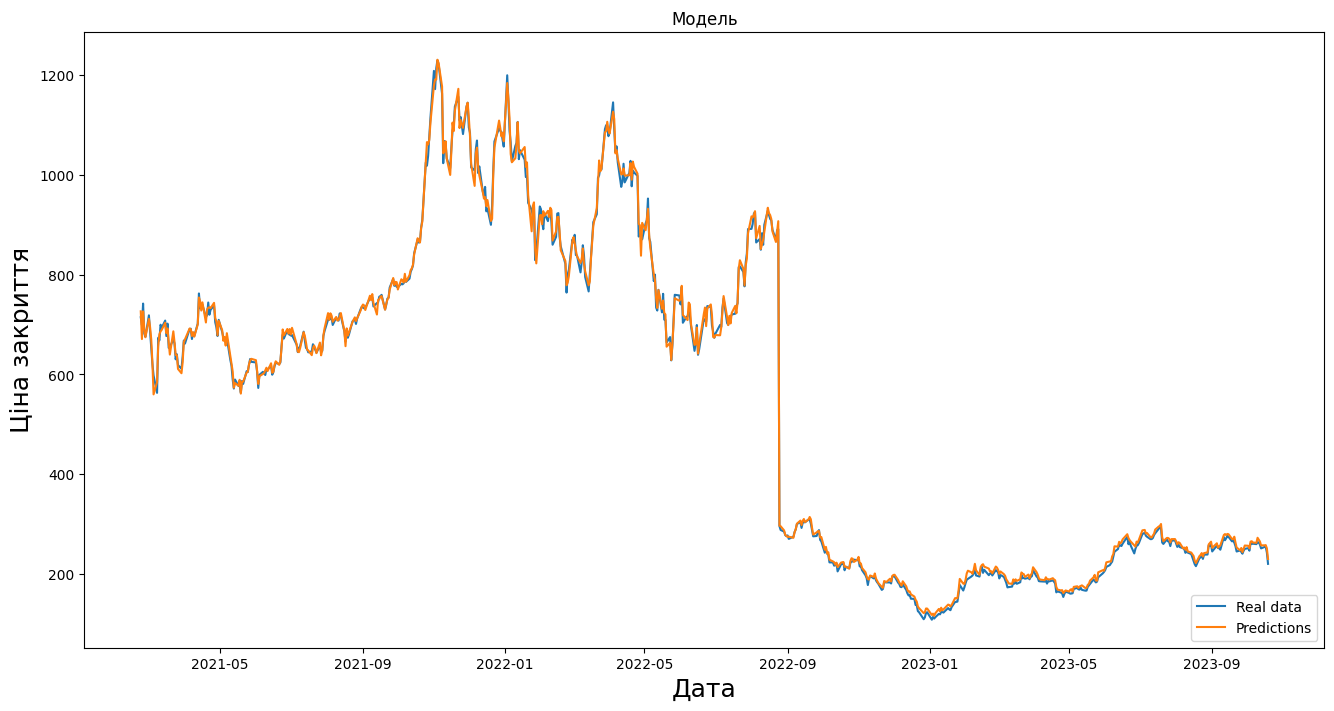

In [329]:
predictions_plot(predictions_tl, y_test_tl)

## Передбачаємо сьогоднішню ціну на акції Tesla

In [330]:
new_data_tl = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=TSLA&outputsize=full&apikey={key}&datatype=csv')

In [331]:
today_data_tl = new_data_tl[new_data_tl['timestamp'] == '2023-10-18']

In [332]:
X_today_data_tl = today_data_tl.filter(['open', 'high', 'low', 'volume']).values
y_today_data_tl = today_data_tl.filter(['close']).values

In [333]:
pred_today_tl = model_tl.predict(X_today_data_tl)

/Users/admin/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [334]:
print(new_data_tl['timestamp'].iloc[0])
print("Передбачувана ціна:", *pred_today_tl)
print("Реальна:", *y_today_data_tl[0])

2023-10-19
Передбачувана ціна: 251.31349012132918
Реальна: 242.68


# Cтворення нейромережі

In [335]:
import math
from sklearn.preprocessing import MinMaxScaler

In [336]:
# Функція для вибору, перетворення та нормалізації даниї для нейромережі
def data_processing(data):
    # беремо лише колонку close
    data = data.filter(['close'])
    # перетворюємо дані в nampy array
    dataset = data.values
    # вираховуємо довжину тренувальних даних
    train_data_len = math.ceil(len(dataset)*0.8)

    # робимо min max нормалізацію
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    train_data = scaled_data[:train_data_len, :]
    X_train, y_train = [], []

    # створюємо фічу. Ціна за остані 60 днів
    # створюємо прогнозоване значення. Прогнозована ціна на основі останіх 60 днів
    for i in range(60, len(train_data)):
        X_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    # перетворюємо дані в nampy array та задаємо розмірність
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # повторюємо дії для тестових даних
    test_data = scaled_data[train_data_len-60:]
    X_test = []
    y_test = dataset[train_data_len:,:]
    
    for i in range(60, len(test_data)):
        X_test.append(test_data[i-60:i, 0])
        
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, X_test, y_train, y_test, scaler, data, train_data_len

In [337]:
def rnn_model():
    model = Sequential()
    
    # Додавання першого LSTM шару з 50 нейронами та вказання розміру вхідних даних
    model.add(LSTM(50, input_shape=(60, 1), return_sequences=True))
    
    # Додавання другого LSTM шару з 50 нейронами, return_sequences=False вказує, що це останній LSTM шар
    model.add(LSTM(50, return_sequences=False)) 
    
    # Додавання повнозв'язаного шару з одним виходним нейроном, який буде відповідати за прогнозоване значення
    model.add(Dense(1)) 

    model.compile(loss='mse', optimizer='adam')
        
    return model

In [338]:
def data_visualization(data, train_data_len, predictions):
    train = data[:train_data_len]
    valid = data[train_data_len:]
    valid['predictions'] = predictions
    
    plt.figure(figsize=(16, 8))
    plt.title('Модель')
    plt.xlabel('Дата', fontsize=18)
    plt.ylabel('Ціна закриття', fontsize=18)
    plt.plot(train['close'])
    plt.plot(valid[['close', 'predictions']])
    plt.legend(['Train', 'Vall', 'Predictions'], loc ='lower right')
    plt.show()

## Навчання та прогноз на даних Amazon

In [367]:
X_train_az, X_test_az, y_train_az, y_test_az, scaler_az, data_az, train_data_len_az = data_processing(df_amazon)

In [368]:
RNN_model_az = rnn_model()

In [369]:
RNN_model_az.fit(X_train_az, y_train_az, batch_size=1, epochs=10, verbose=2)

Epoch 1/10
4765/4765 - 180s - loss: 1.9858e-04 - 180s/epoch - 38ms/step
Epoch 2/10
4765/4765 - 137s - loss: 9.1910e-05 - 137s/epoch - 29ms/step
Epoch 3/10
4765/4765 - 128s - loss: 5.2759e-05 - 128s/epoch - 27ms/step
Epoch 4/10
4765/4765 - 141s - loss: 4.2024e-05 - 141s/epoch - 30ms/step
Epoch 5/10
4765/4765 - 163s - loss: 4.6857e-05 - 163s/epoch - 34ms/step
Epoch 6/10
4765/4765 - 127s - loss: 3.3760e-05 - 127s/epoch - 27ms/step
Epoch 7/10
4765/4765 - 119s - loss: 3.0969e-05 - 119s/epoch - 25ms/step
Epoch 8/10
4765/4765 - 151s - loss: 3.2069e-05 - 151s/epoch - 32ms/step
Epoch 9/10
4765/4765 - 151s - loss: 3.0151e-05 - 151s/epoch - 32ms/step
Epoch 10/10
4765/4765 - 142s - loss: 2.3633e-05 - 142s/epoch - 30ms/step


In [370]:
predictions_az = RNN_model_az.predict(X_test_az)

38/38 [==============================] - 5s 26ms/step


In [371]:
predictions_az = scaler_az.inverse_transform(predictions_az)

In [372]:
rmse_az = np.sqrt(np.mean(predictions_az - y_test_az)**2)

In [373]:
rmse_az

4.252801886917536

/var/folders/y6/0v8f_ns90nnct7qv3jxpbx9r0000gn/T/ipykernel_18871/1168982147.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


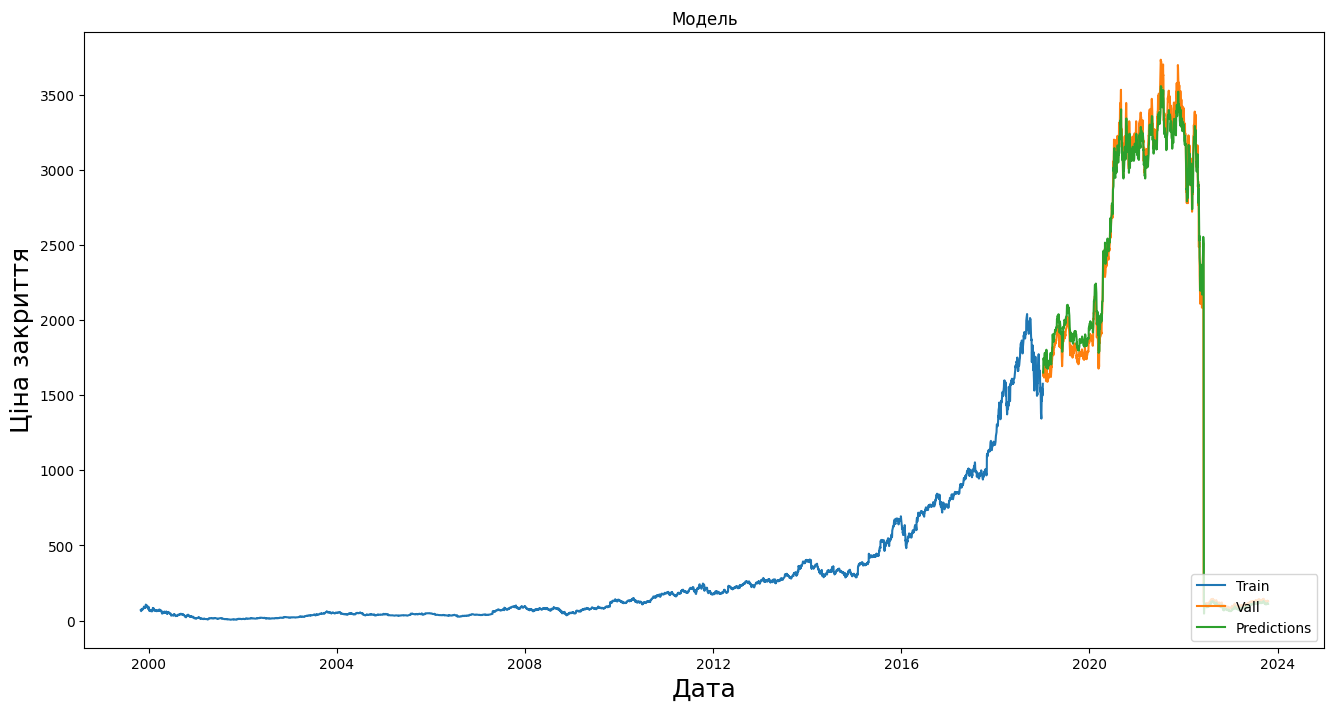

In [374]:
data_visualization(data_az, train_data_len_az, predictions_az)

## Передбачаємо сьогоднішню ціну на акції Amazon

In [375]:
new_data_az = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AMZN&outputsize=compact&apikey={key}&datatype=csv')

In [376]:
new_data_az.head()

,timestamp,open,high,low,close,volume
0,2023-10-19,130.565,132.2400,127.470,128.40,60961355
1,2023-10-18,129.900,130.6699,127.510,128.13,42699479
2,2023-10-17,130.390,132.5800,128.710,131.47,49344550
3,2023-10-16,130.690,133.0700,130.425,132.55,42832918
4,2023-10-13,132.980,133.3145,128.950,129.79,45824685


In [377]:
train_data_az = new_data_az.filter(['close'])
#сьогоднішня ціна яку ми будемо передбачати
Y = train_data_az.iloc[0]

last_60_days_az = train_data_az[1:60].values
last_60_days_scaled_az = scaler_az.transform(last_60_days_az)

X_test_az = np.array([last_60_days_scaled_az])
X_test_az = np.reshape(X_test_az, (X_test_az.shape[0], X_test_az.shape[1], 1))

In [378]:
pred_az = RNN_model_az.predict(X_test_az)

1/1 [==============================] - 1s 1s/step


In [379]:
pred_az = scaler_az.inverse_transform(pred_az)

In [380]:
print(new_data_az['timestamp'].iloc[0])
print("Передбачувана ціна:", *pred_az[0])
print("Реальна:", Y)

2023-10-19
Передбачувана ціна: 112.189415
Реальна: close    128.4
Name: 0, dtype: float64


## Навчання та прогноз на даних Tesla

In [381]:
X_train_tl, X_test_tl, y_train_tl, y_test_tl, scaler_tl, data_tl, train_data_len_tl = data_processing(df_tesla)

In [382]:
RNN_model_tl = rnn_model()

In [383]:
RNN_model_tl.fit(X_train_tl, y_train_tl, batch_size=1, epochs=10, verbose=2)

Epoch 1/10
2621/2621 - 83s - loss: 0.0025 - 83s/epoch - 32ms/step
Epoch 2/10
2621/2621 - 78s - loss: 9.5113e-04 - 78s/epoch - 30ms/step
Epoch 3/10
2621/2621 - 80s - loss: 8.4628e-04 - 80s/epoch - 30ms/step
Epoch 4/10
2621/2621 - 79s - loss: 0.0010 - 79s/epoch - 30ms/step
Epoch 5/10
2621/2621 - 90s - loss: 6.6387e-04 - 90s/epoch - 34ms/step
Epoch 6/10
2621/2621 - 91s - loss: 6.0851e-04 - 91s/epoch - 35ms/step
Epoch 7/10
2621/2621 - 92s - loss: 5.0836e-04 - 92s/epoch - 35ms/step
Epoch 8/10
2621/2621 - 98s - loss: 6.3436e-04 - 98s/epoch - 37ms/step
Epoch 9/10
2621/2621 - 90s - loss: 5.2361e-04 - 90s/epoch - 34ms/step
Epoch 10/10
2621/2621 - 73s - loss: 5.0192e-04 - 73s/epoch - 28ms/step


In [384]:
predictions_tl = RNN_model_tl.predict(X_test_tl)

21/21 [==============================] - 2s 24ms/step


In [385]:
predictions_tl = scaler_tl.inverse_transform(predictions_tl)

In [386]:
rmse_tl = np.sqrt(np.mean(predictions_tl - y_test_tl)**2)

In [387]:
rmse_tl

0.044415788792852386

/var/folders/y6/0v8f_ns90nnct7qv3jxpbx9r0000gn/T/ipykernel_18871/1168982147.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


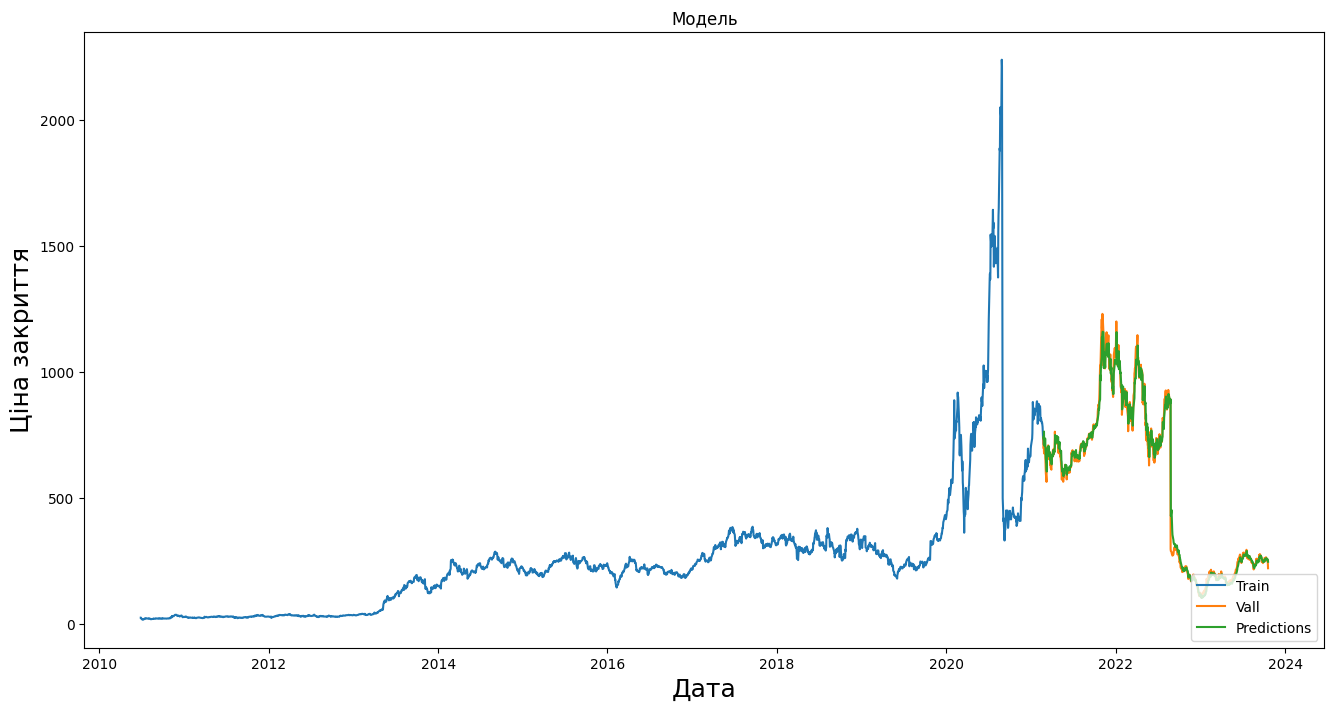

In [388]:
data_visualization(data_tl, train_data_len_tl, predictions_tl)

## Передбачаємо сьогоднішню ціну на акції Tesla

In [389]:
new_data_tl = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=TSLA&outputsize=compact&apikey={key}&datatype=csv')

In [390]:
new_data_tl.head()

,timestamp,open,high,low,close,volume
0,2023-10-19,225.95,230.6100,216.78,220.11,170772713
1,2023-10-18,252.70,254.6300,242.08,242.68,125147846
2,2023-10-17,250.10,257.1830,247.08,254.85,93562909
3,2023-10-16,250.05,255.3999,248.48,253.92,88917176
4,2023-10-13,258.90,259.6000,250.22,251.12,102296786


In [391]:
train_data_tl = new_data_tl.filter(['close'])
#сьогоднішня ціна яку ми будемо передбачати
Y = train_data_tl.iloc[0]

last_60_days_tl = train_data_tl[1:60].values
last_60_days_scaled_tl = scaler_tl.transform(last_60_days_tl)

X_test_tl = np.array([last_60_days_scaled_tl])
X_test_tl = np.reshape(X_test_tl, (X_test_tl.shape[0], X_test_tl.shape[1], 1))

In [392]:
pred_tl = RNN_model_tl.predict(X_test_tl)

1/1 [==============================] - 1s 956ms/step


In [393]:
pred_tl = scaler_tl.inverse_transform(pred_tl)

In [394]:
print(new_data_tl['timestamp'].iloc[0])
print("Передбачувана ціна:", *pred_tl[0])
print("Реальна:", *Y)

2023-10-19
Передбачувана ціна: 254.59811
Реальна: 220.11
